In [1]:
import torch
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from scarches.dataset.trvae.data_handling import remove_sparsity
from lataq.models import EMBEDCVAE
from lataq.exp_dict import EXPERIMENT_INFO

sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=500)
plt.rcParams['figure.figsize'] = (5, 5)
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

%load_ext autoreload
%autoreload 2

In [2]:
PARAMS = {
    'EPOCHS': 100,                                      #TOTAL TRAINING EPOCHS
    'N_PRE_EPOCHS': 80,                                #EPOCHS OF PRETRAINING WITHOUT LANDMARK LOSS
    'DATA_DIR': '../../lataq_reproduce/data',          #DIRECTORY WHERE THE DATA IS STORED
    'DATA': 'pbmc_anndata.h5ad',                            #DATA USED FOR THE EXPERIMENT
    'EARLY_STOPPING_KWARGS': {                         #KWARGS FOR EARLY STOPPING
        "early_stopping_metric": "val_landmark_loss",  ####value used for early stopping
        "mode": "min",                                 ####choose if look for min or max
        "threshold": 0,
        "patience": 20,
        "reduce_lr": True,
        "lr_patience": 13,
        "lr_factor": 0.1,
    },
    'LABELED_LOSS_METRIC': 'dist',           
    'UNLABELED_LOSS_METRIC': 'dist',
    'LATENT_DIM': 25,
    'ALPHA_EPOCH_ANNEAL': 1e6,
    'CLUSTERING_RES': 2,
    'HIDDEN_LAYERS': 3,
    'ETA': 10,
}

In [6]:
adata = sc.read(
    f'../data/pbmc_anndata.h5ad'
)
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
ann_levels = [1, 2, 3]
condition_key = "donor"
cell_type_key = [f"celltype.l{i}" for i in ann_levels]
query = ["P3", "P6"]
reference = ["P1", "P2", "P4", "P5", "P7", "P8"]
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs[condition_key].isin(reference)].copy()
target_adata = adata[adata.obs[condition_key].isin(query)].copy()

In [4]:
lataq_model = EMBEDCVAE(
    adata=source_adata,
    condition_key=condition_key,
    cell_type_keys=cell_type_key,
    hidden_layer_sizes=[128]*int(PARAMS['HIDDEN_LAYERS']),
    latent_dim=PARAMS['LATENT_DIM'],
)

Embedding dictionary:
 	Num conditions: 6
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 20729 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Output Layer in/out:  128 20729 



In [5]:
lataq_model.train(
    n_epochs=PARAMS['EPOCHS'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    eta=PARAMS['ETA'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

KeyboardInterrupt: 

In [6]:
lataq_model.save('tmp/', overwrite=True)

In [7]:
lataq_query = lataq_model.load_query_data(
    adata=target_adata,
    reference_model='tmp/',
    labeled_indices=[],
)

AnnData object with n_obs × n_vars = 3289 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
    obsm: 'X_seurat', 'X_symphony'
Embedding dictionary:
 	Num conditions: 9
 	Embedding dim: 10
Encoder Architecture:
	Input Layer in, out and cond: 4000 128 0
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Mean/Var Layer in/out: 128 25
Decoder Architecture:
	First Layer in, out and cond:  25 128 10
	Hidden Layer 1 in/out: 128 128
	Hidden Layer 2 in/out: 128 128
	Hidden Layer 3 in/out: 128 128
	Hidden Layer 4 in/out: 128 128
	Output Layer in/out:  128 4000 



In [8]:
lataq_query.train(
    n_epochs=PARAMS['EPOCHS'],
    early_stopping_kwargs=PARAMS['EARLY_STOPPING_KWARGS'],
    alpha_epoch_anneal=PARAMS['ALPHA_EPOCH_ANNEAL'],
    pretraining_epochs=PARAMS['N_PRE_EPOCHS'],
    clustering_res=PARAMS['CLUSTERING_RES'],
    eta=PARAMS['ETA'],
    labeled_loss_metric=PARAMS['LABELED_LOSS_METRIC'],
    unlabeled_loss_metric=PARAMS['UNLABELED_LOSS_METRIC'],
)

 |████████████████----| 80.0%  - val_loss: 2115.8343912760 - val_trvae_loss: 2115.8343912760
Initializing unlabeled landmarks with Leiden-Clustering with an unknown number of clusters.
Leiden Clustering succesful. Found 13 clusters.
 |██████████████████--| 90.6%  - val_loss: 2120.6796875000 - val_trvae_loss: 2120.6790364583 - val_landmark_loss: 0.0006850556 - val_unlabeled_loss: 0.6850555340
ADJUSTED LR
 |██████████████████--| 92.0%  - val_loss: 2129.4800618490 - val_trvae_loss: 2129.4794108073 - val_landmark_loss: 0.0006396744 - val_unlabeled_loss: 0.6396743258
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 400


In [9]:
results_dict = lataq_query.classify(
    adata.X, 
    adata.obs[condition_key], 
    metric=PARAMS['LABELED_LOSS_METRIC'],
)
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key[i]]['preds']
    probs = results_dict[cell_type_key[i]]['probs']
    classification_df = pd.DataFrame(
        classification_report(
            y_true=adata.obs[cell_type_key[i]], 
            y_pred=preds,
            output_dict=True
        )
    ).transpose()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

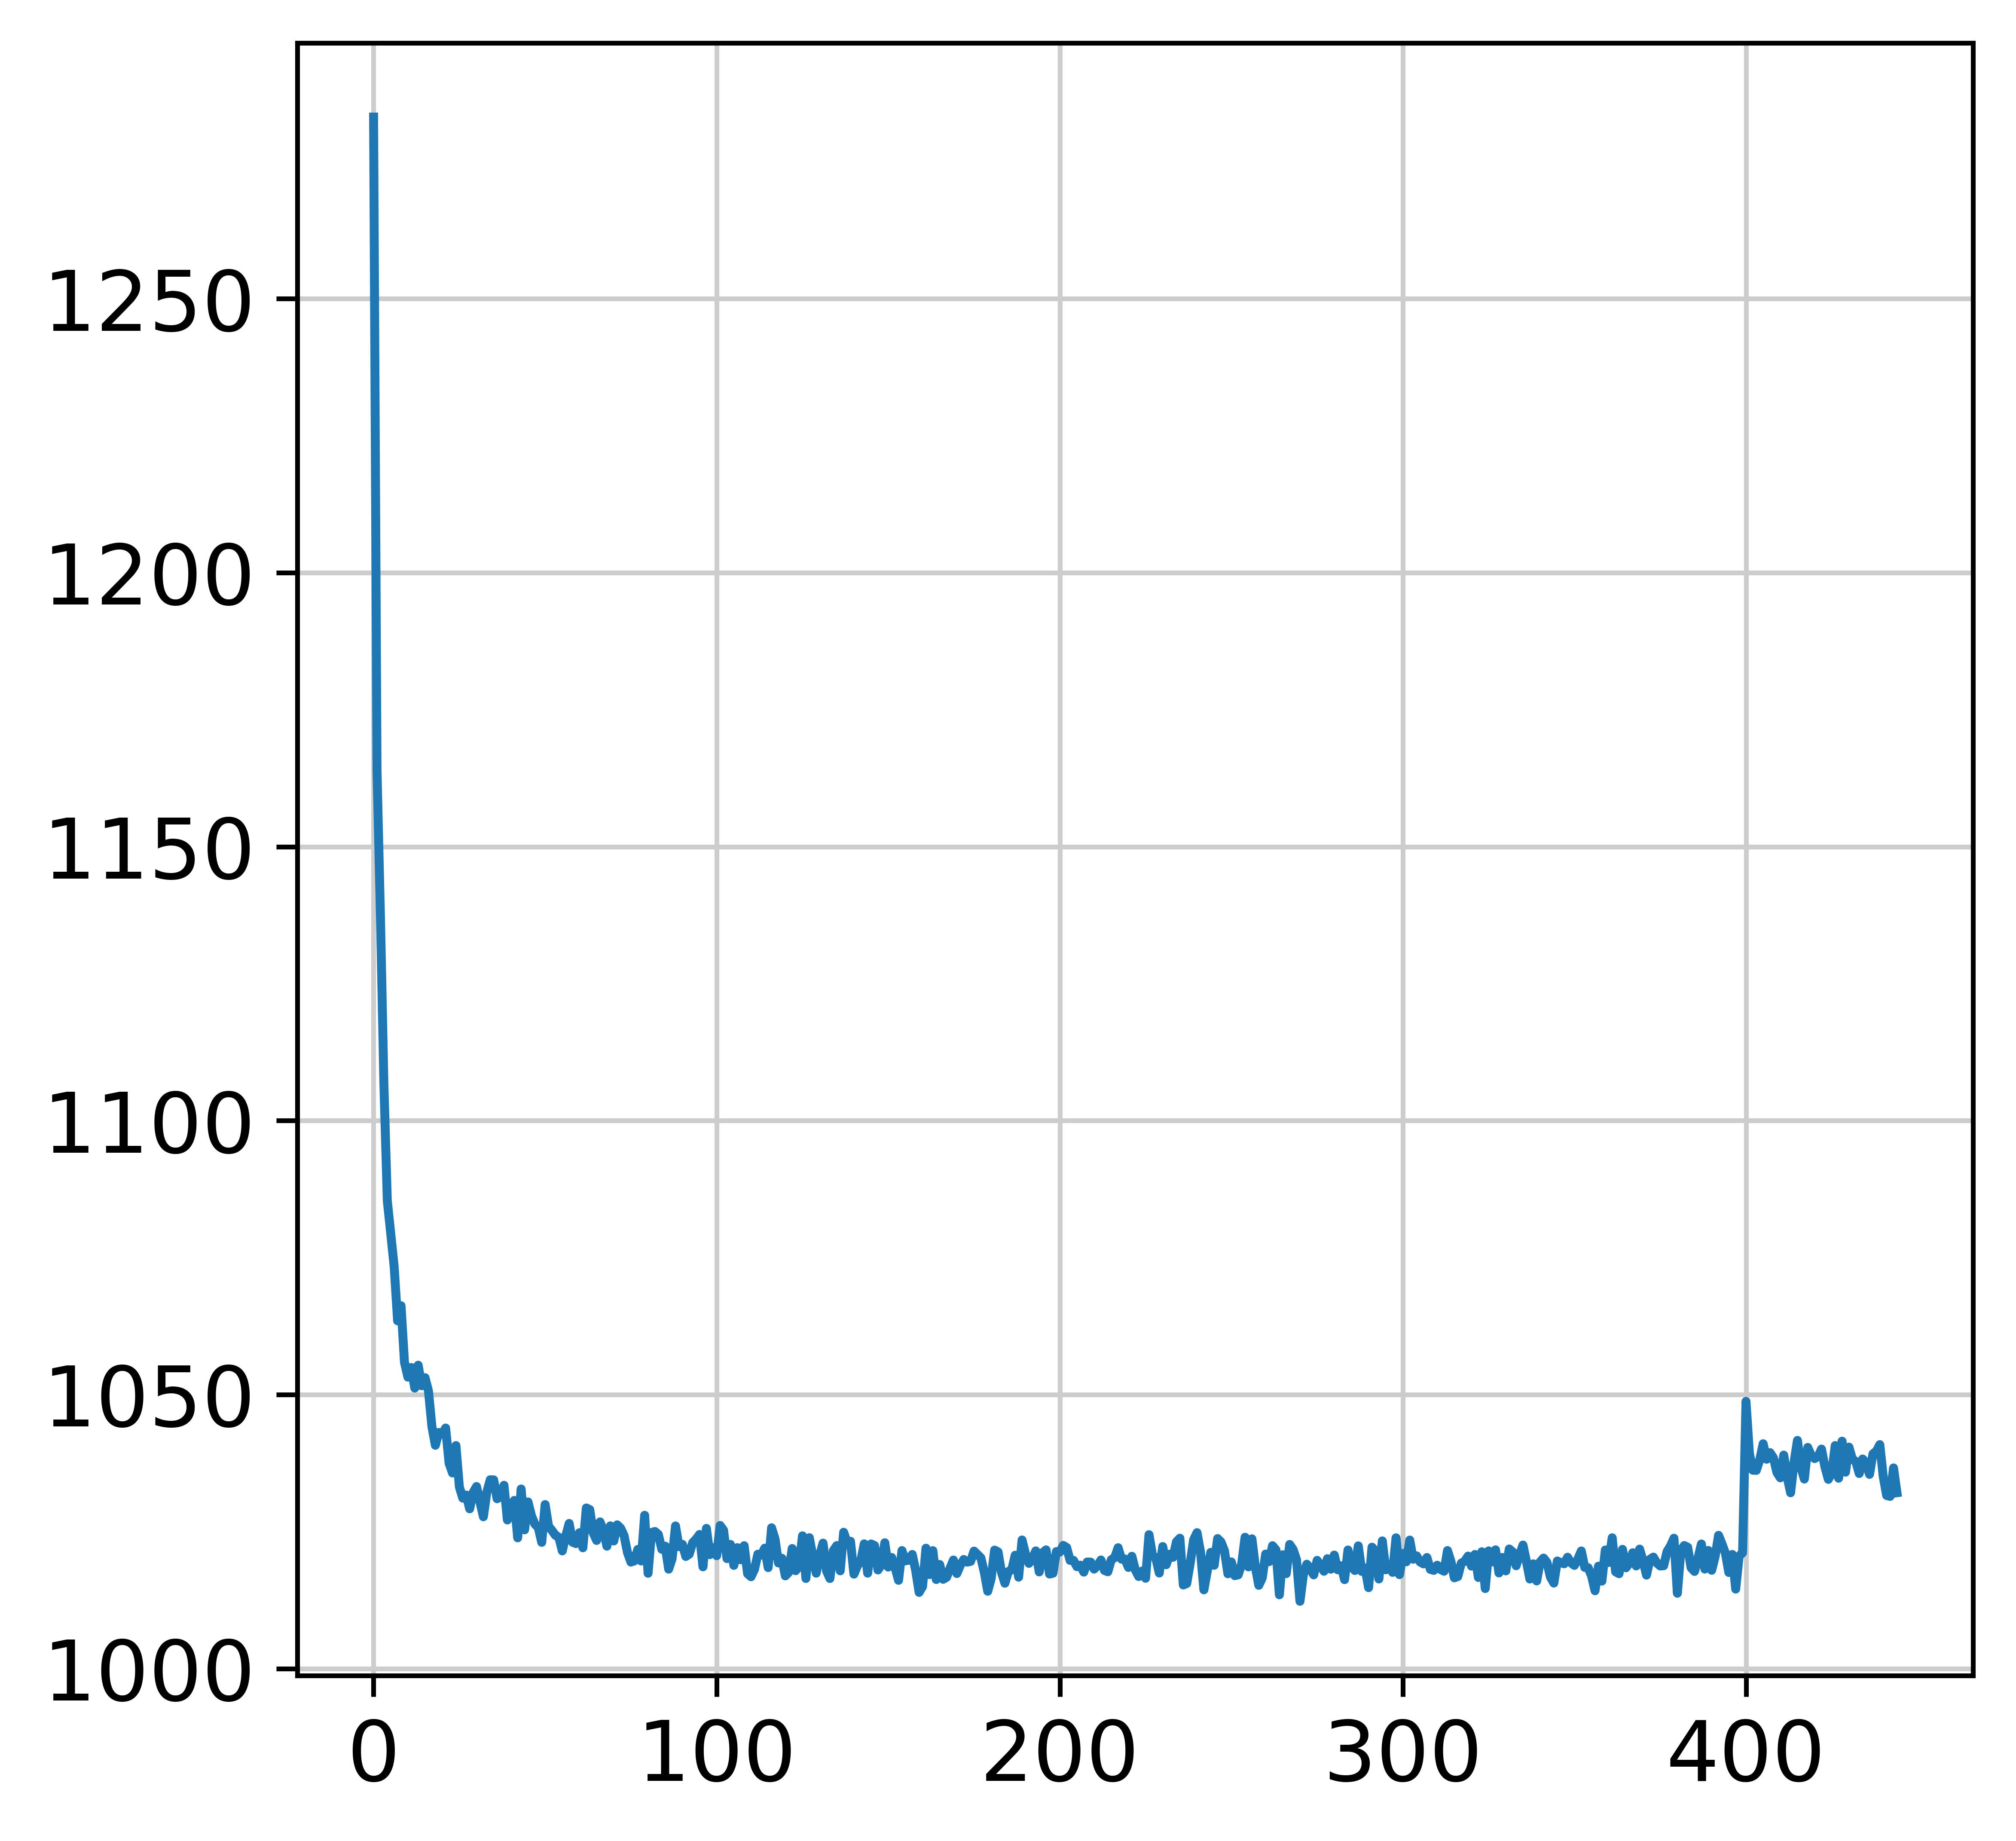

In [10]:
plt.plot(lataq_model.trainer.logs['epoch_loss'])

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


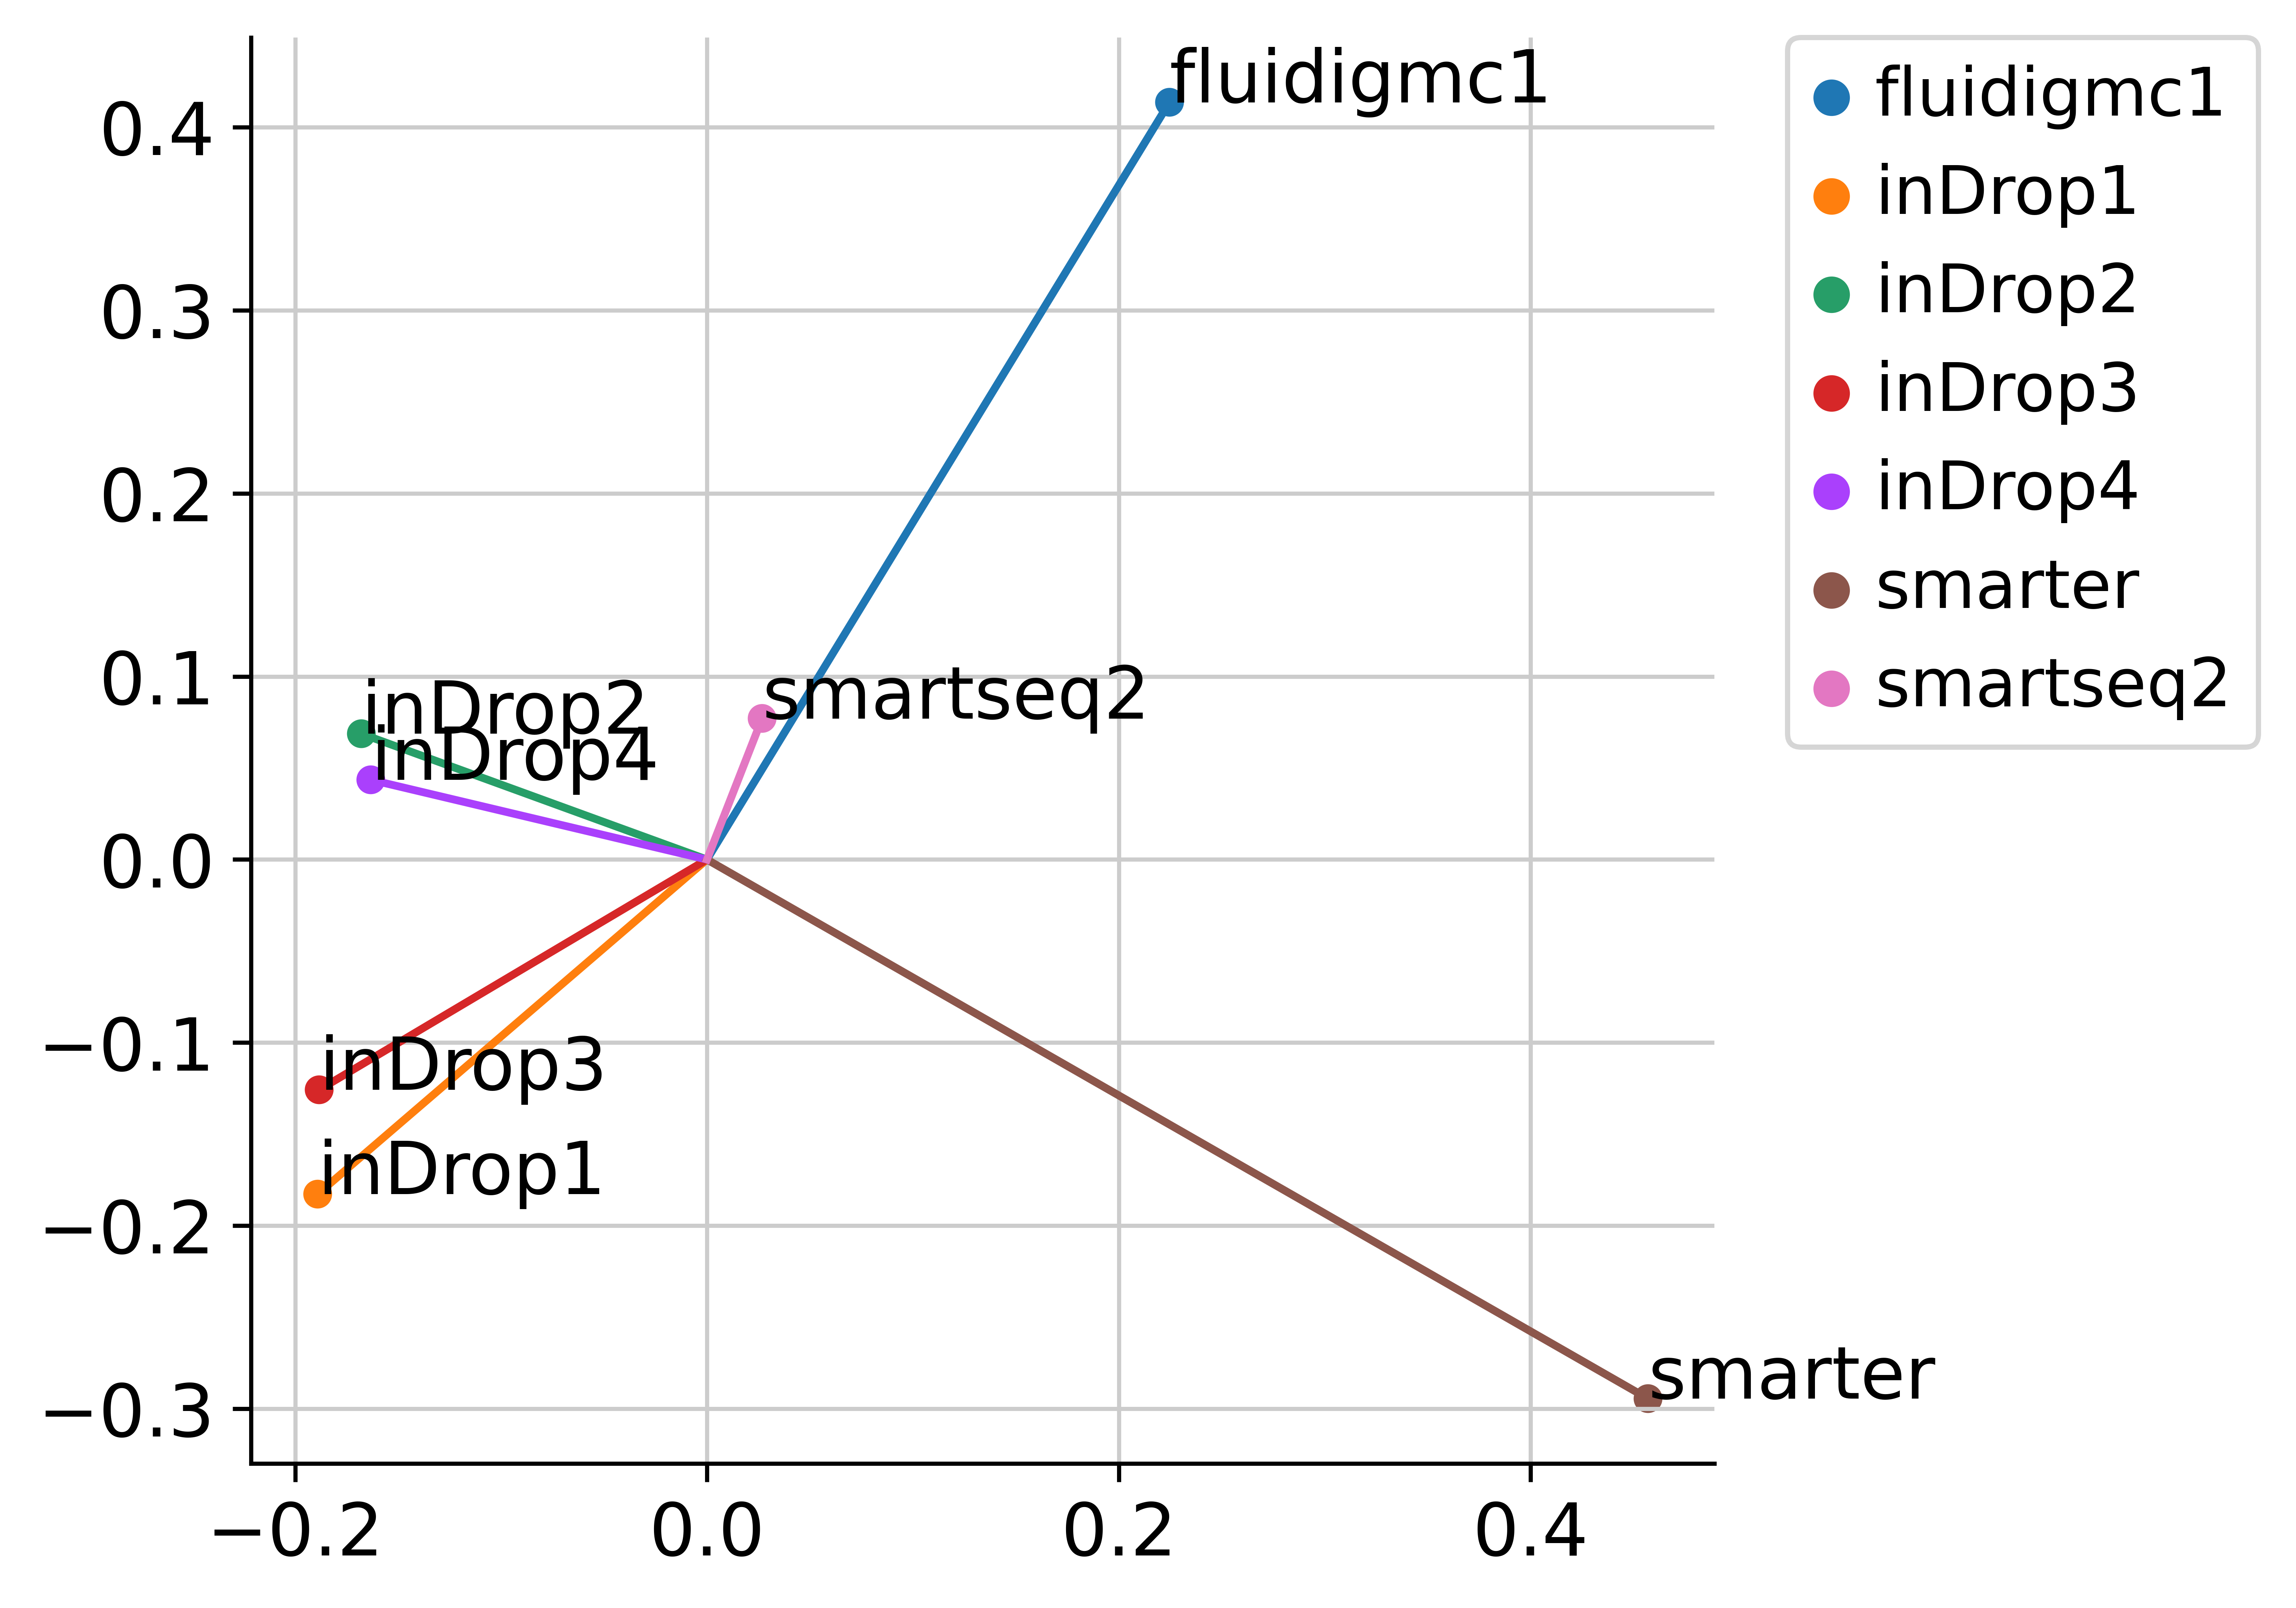

In [17]:
embedding = lataq_model.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='linear')
emb_pca = pca.fit_transform(embedding)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], source_adata.obs[condition_key].unique(), ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(source_adata.obs[condition_key].unique()):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


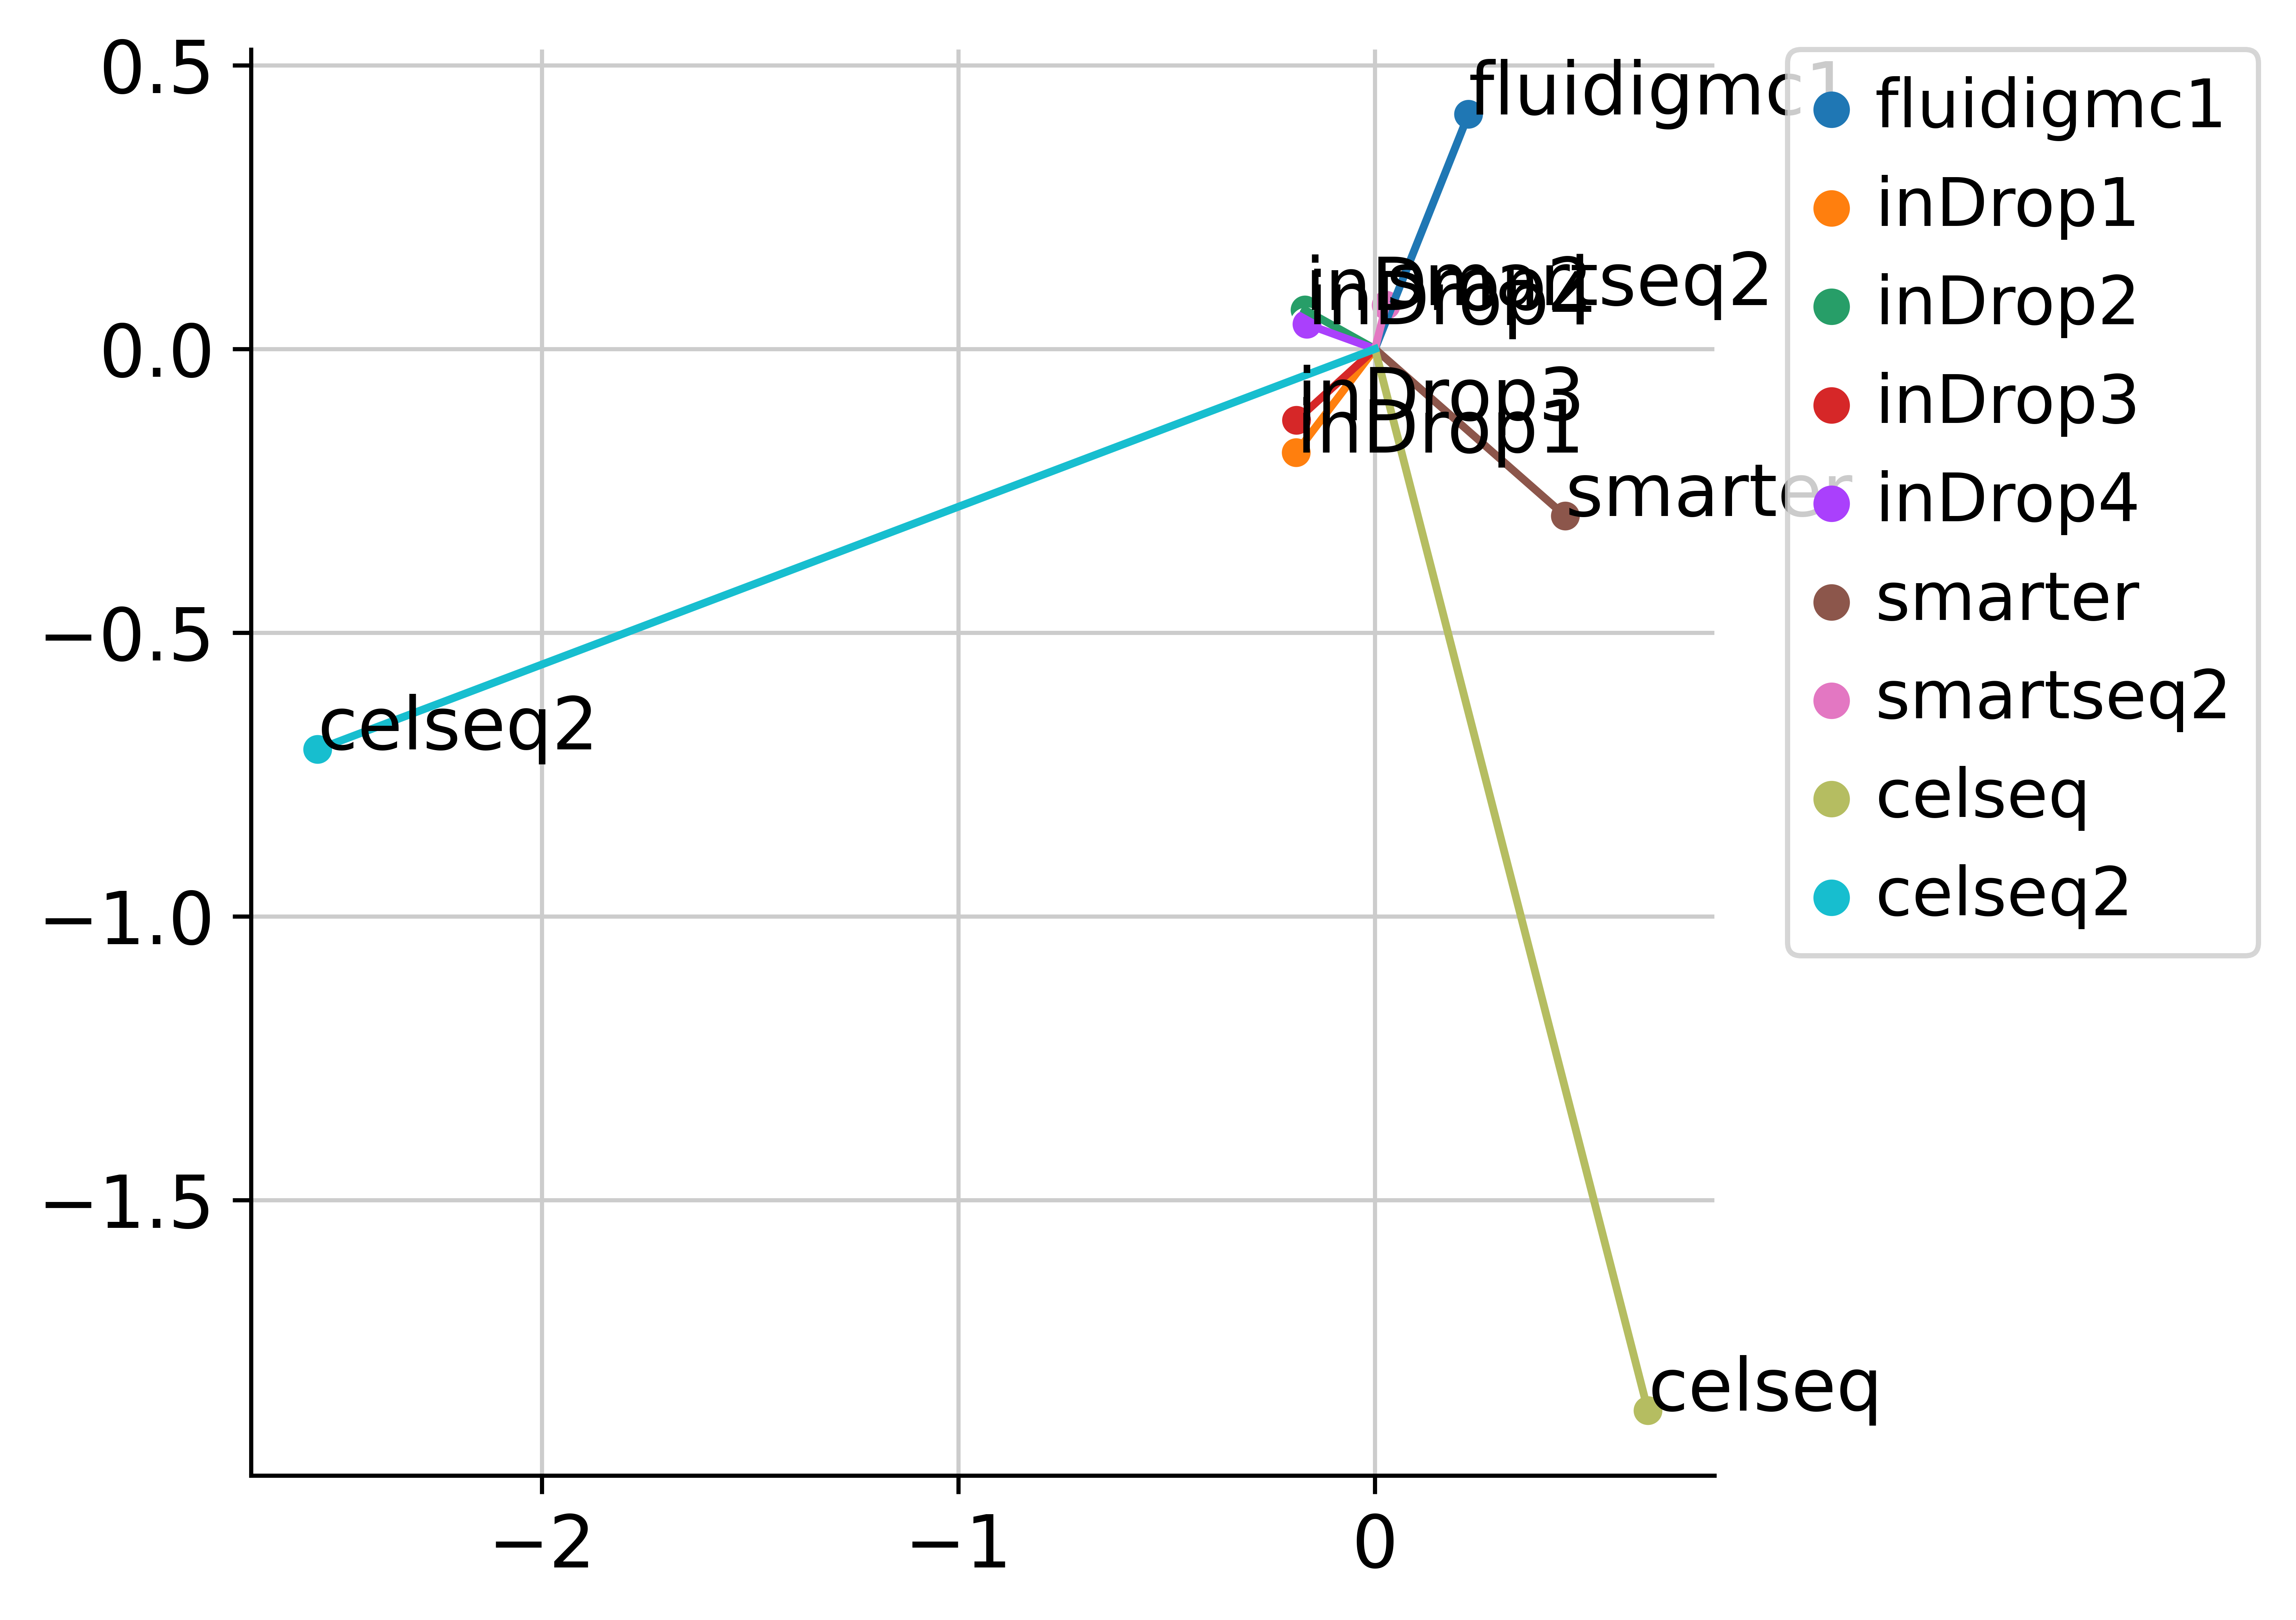

In [18]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
#pca = KernelPCA(n_components=2, kernel='linear')
#emb_pca = pca.fit_transform(embedding)
emb_pca = pca.transform(embedding)
conditions = lataq_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

/home/icb/carlo.dedonno/anaconda3/envs/lataq_cuda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


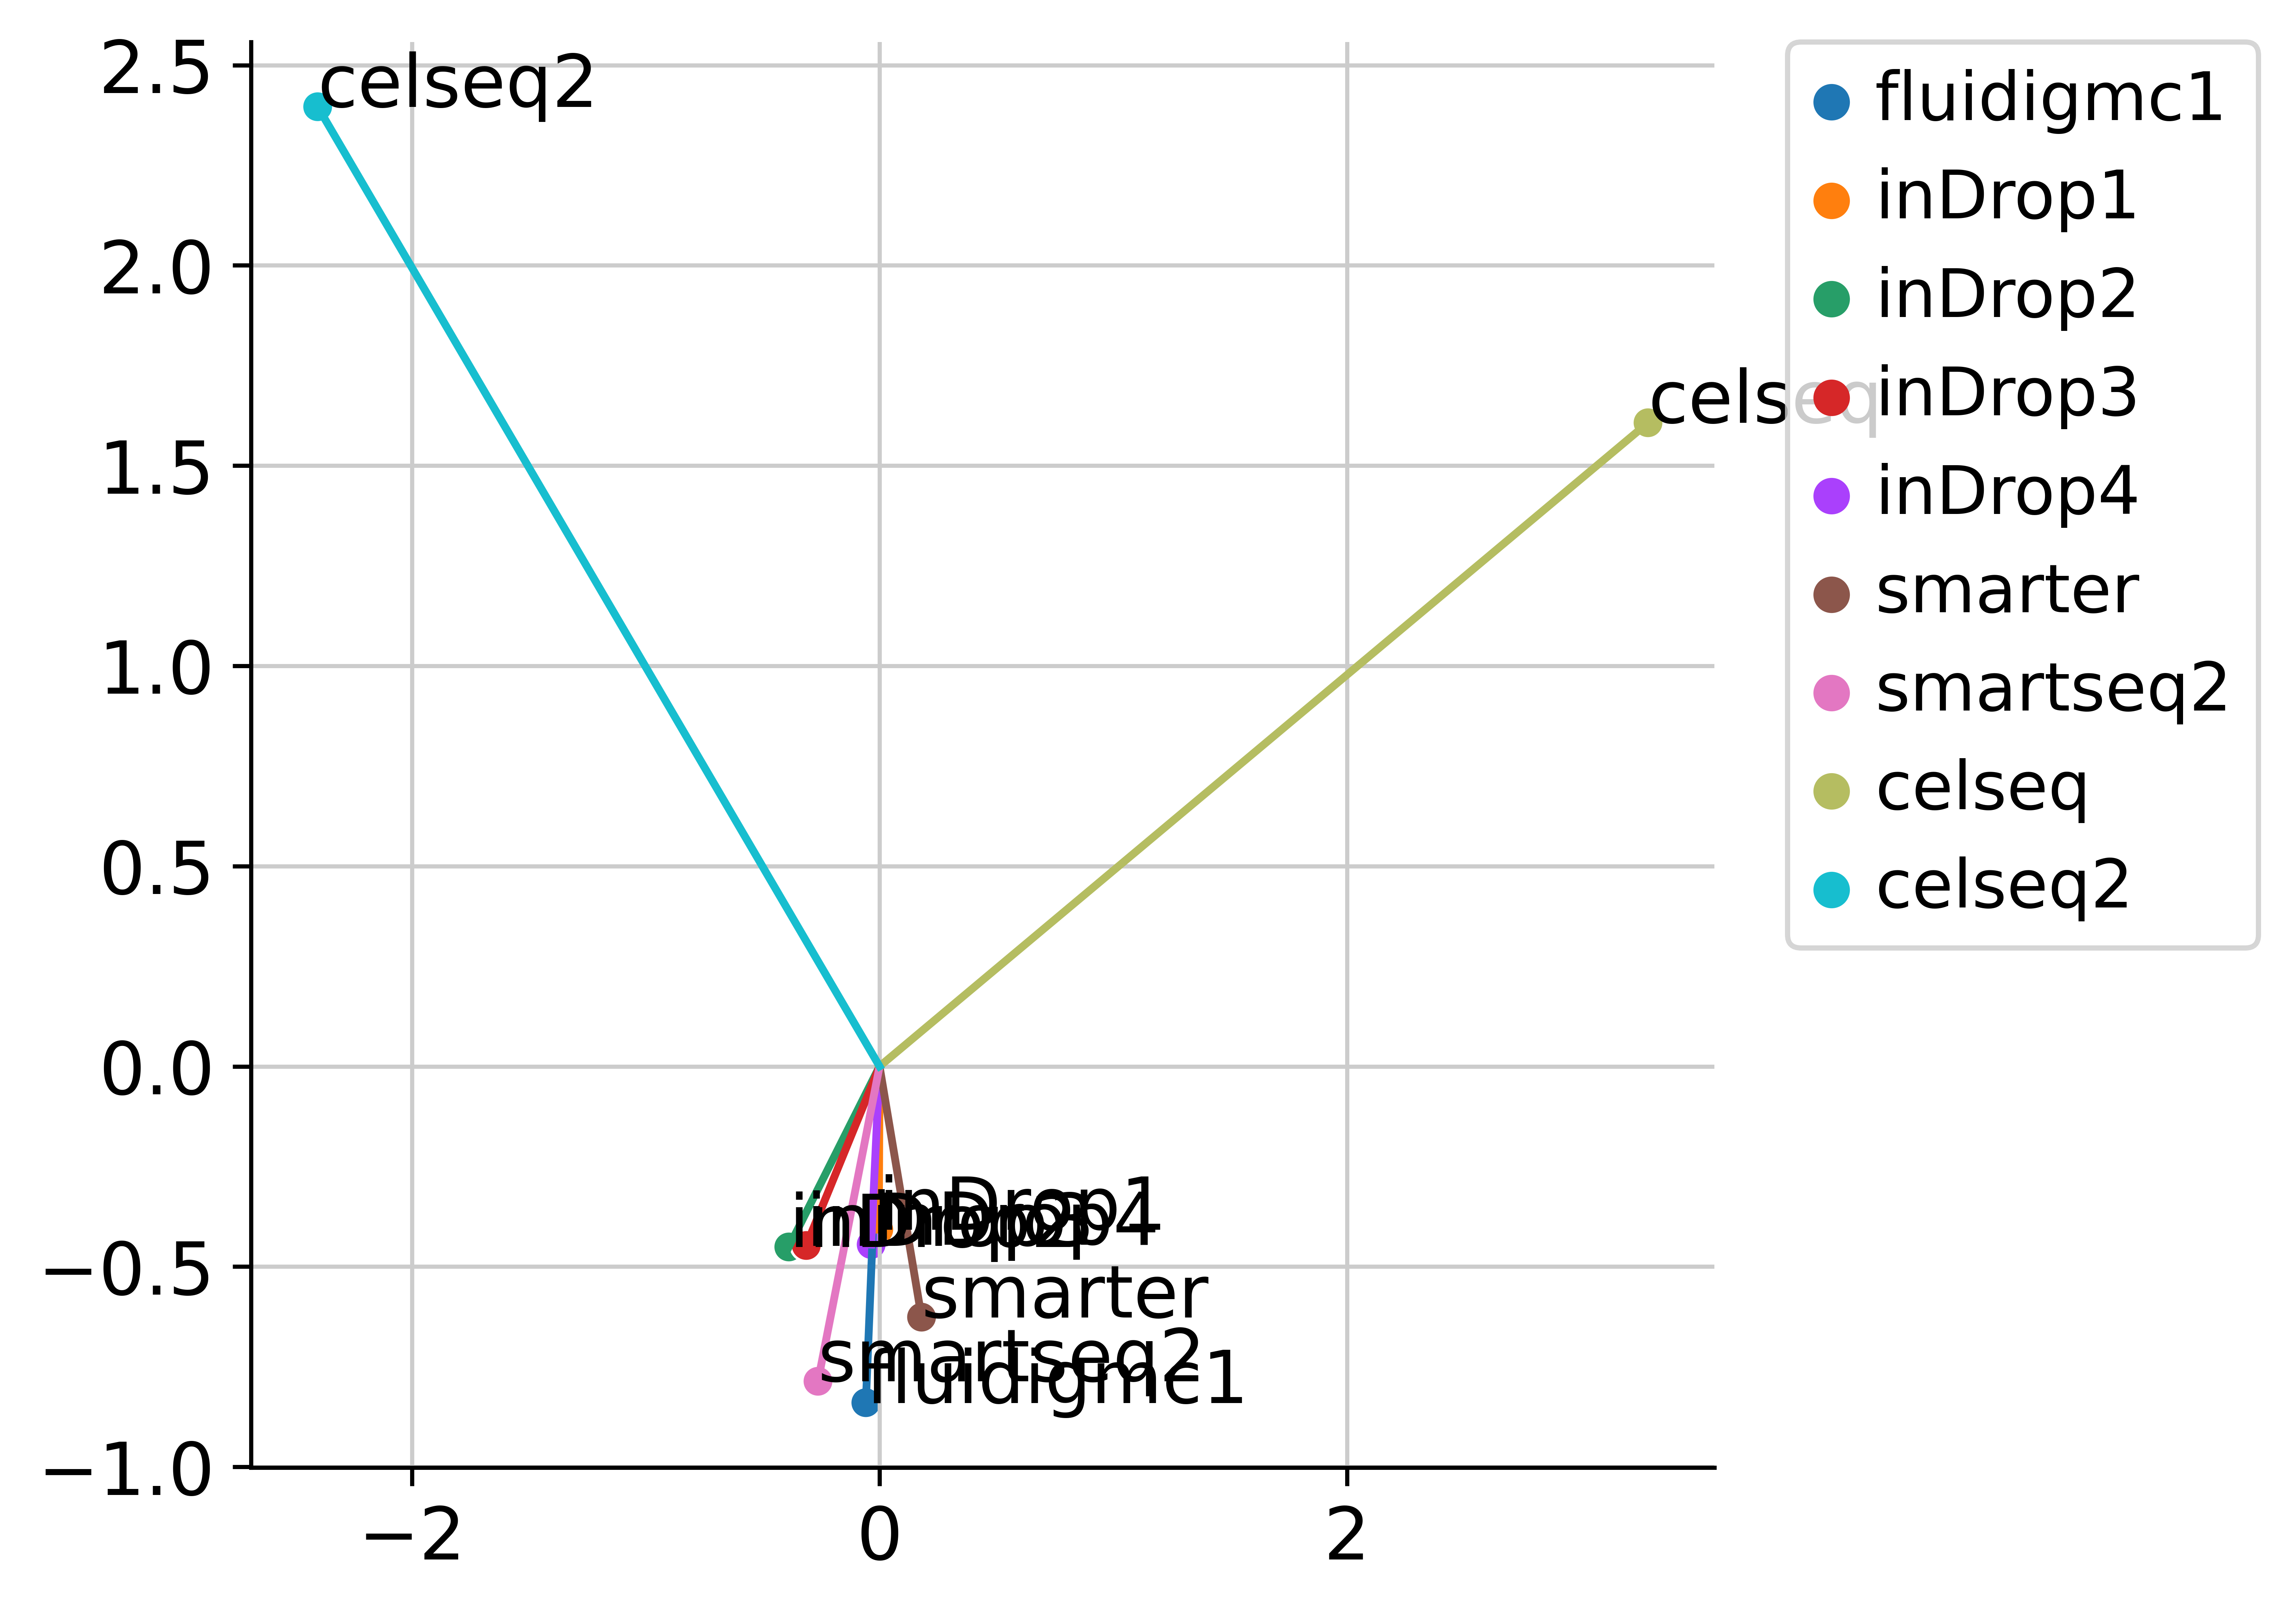

In [19]:
embedding = lataq_query.model.embedding.weight.detach().cpu().numpy()
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='linear')
emb_pca = pca.fit_transform(embedding)
#emb_pca = pca.transform(embedding)
conditions = lataq_query.conditions_
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
import seaborn as sns
sns.scatterplot(emb_pca[:, 0], emb_pca[:, 1], conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()

{'cell_type': {'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'epsilon', 'schwann', 'quiescent_stellate', 'quiescent_stellate',
       'quiescent_stellate', 'quiescent_stellate', 'quiescent_stellate'],
      dtype='<U18'), 'probs': array([0.3 , 0.35, 0.35, 0.34, 0.38, 0.32, 0.36, ..., 0.32, 0.45, 0.36,
       0.34, 0.35, 0.34, 0.35], dtype=float32)}}


... storing 'batch' as categorical


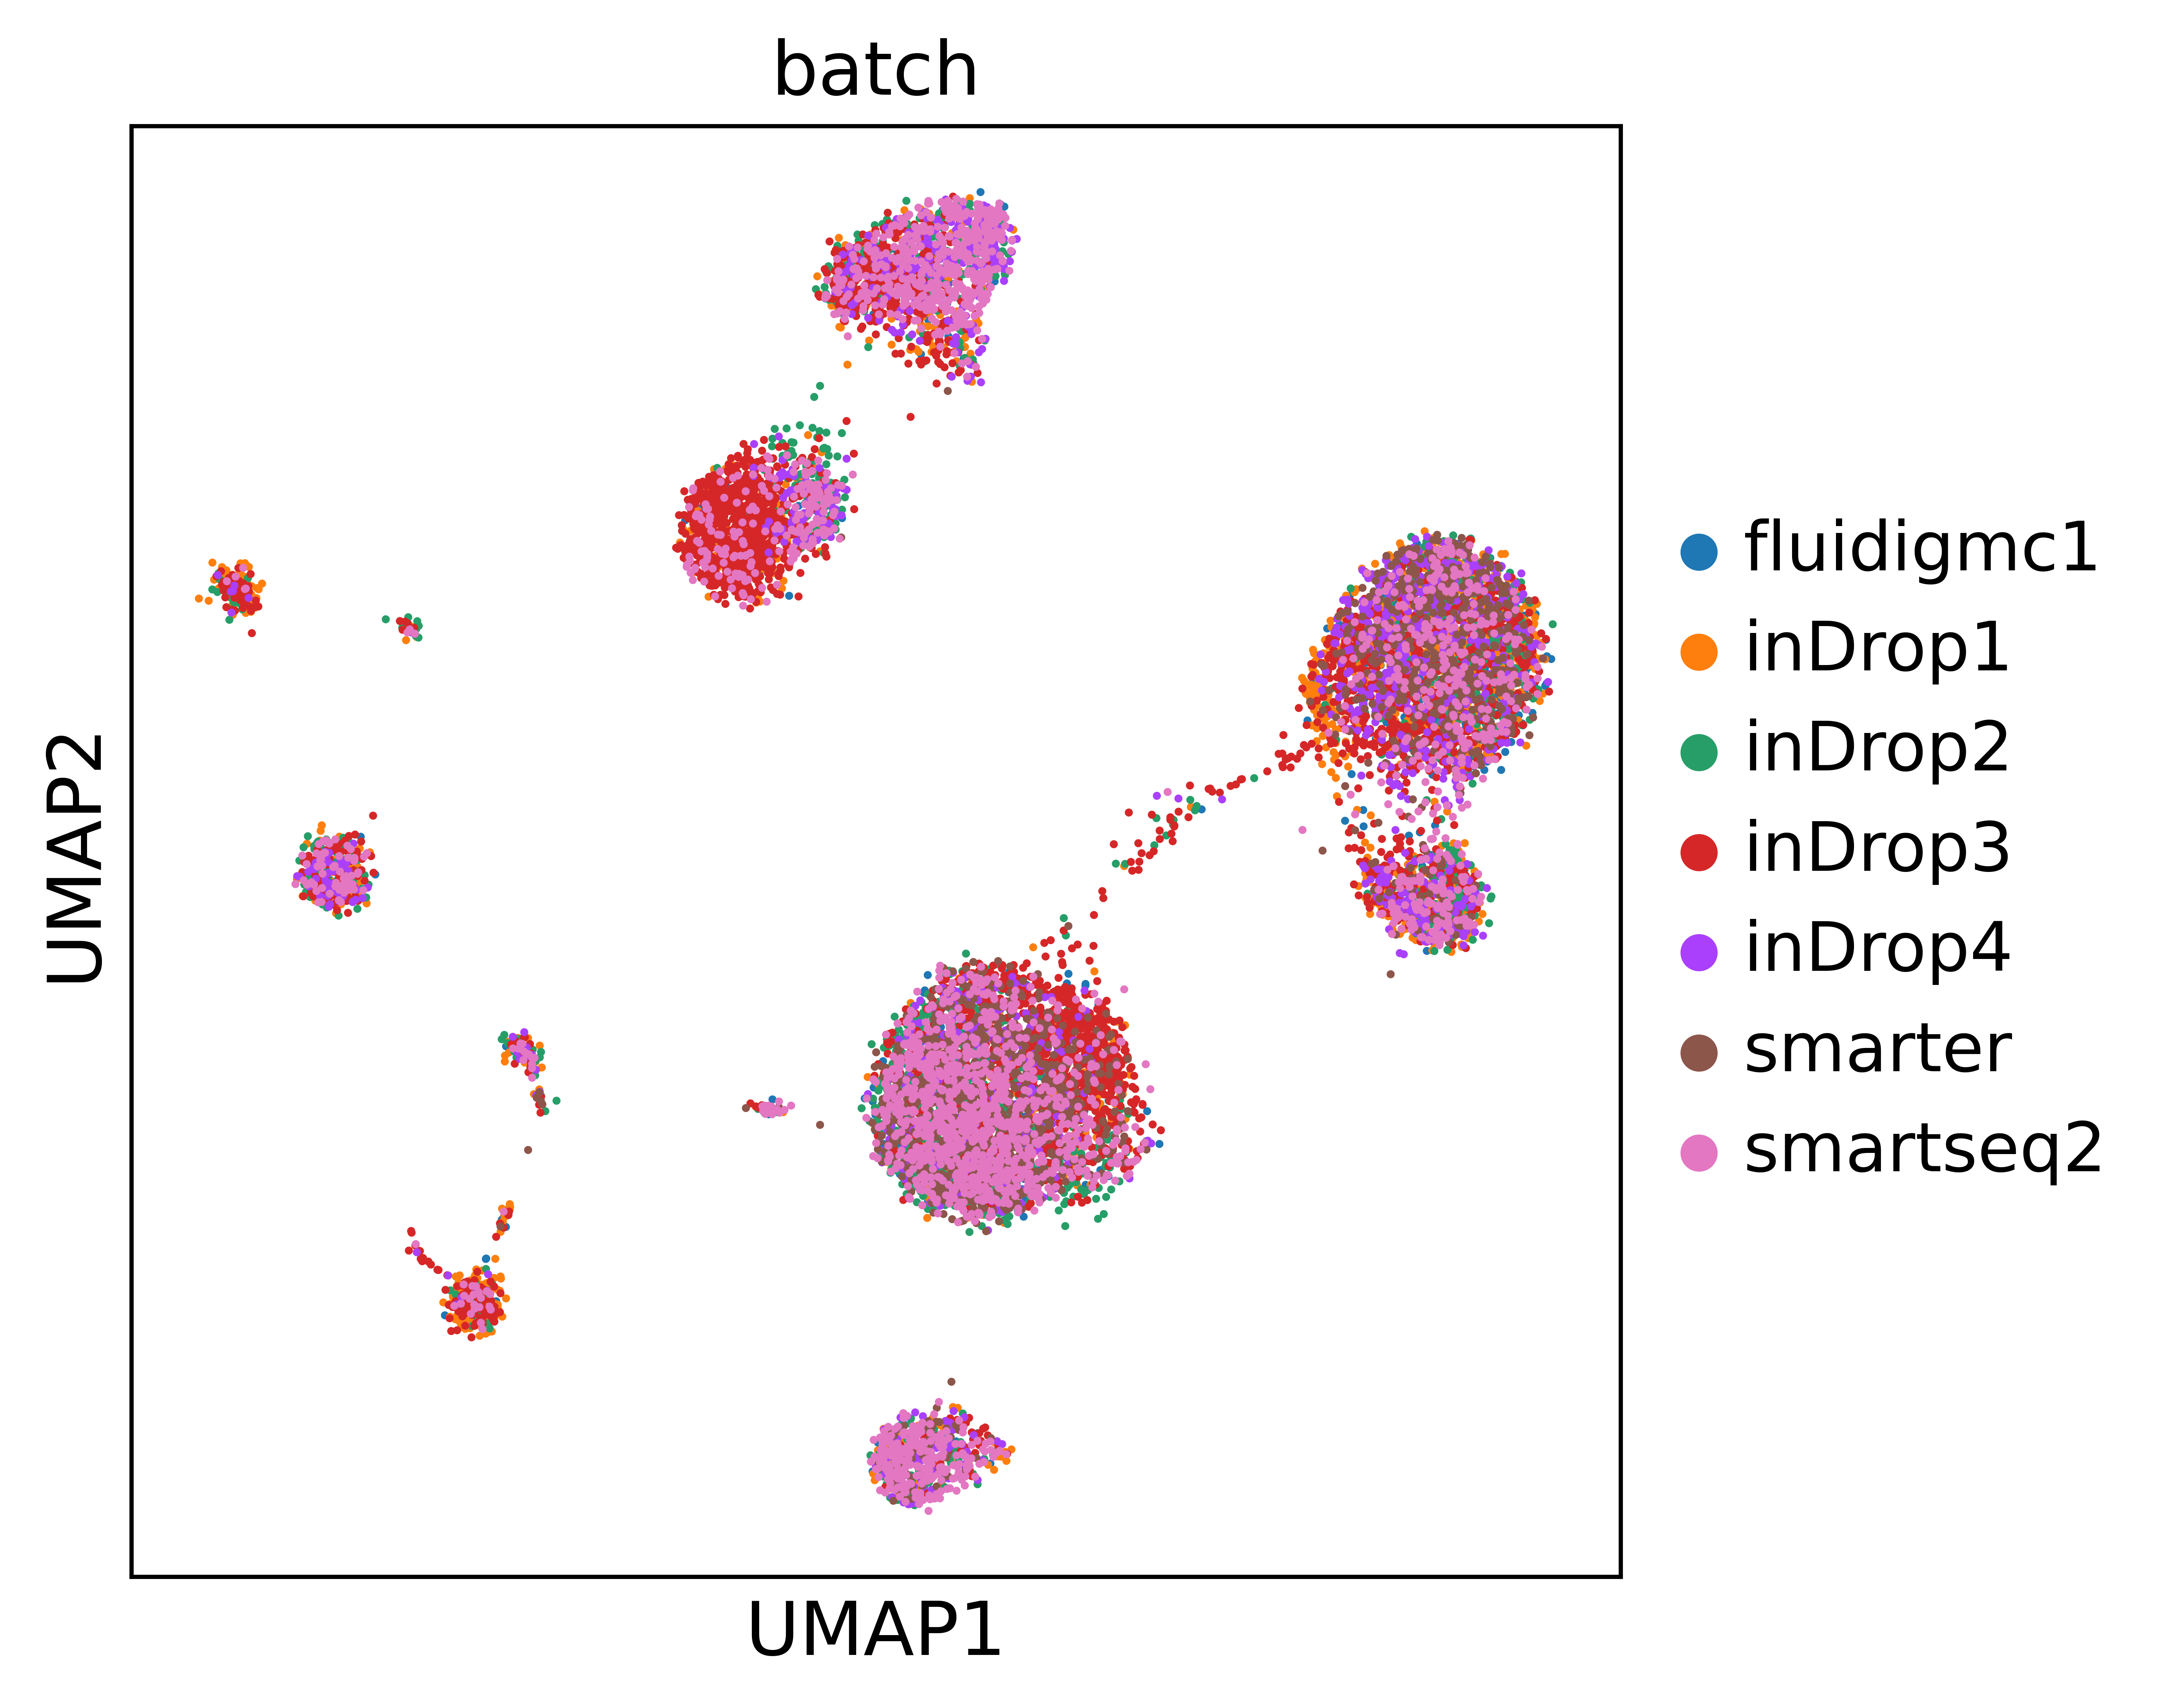

In [13]:
data_latent = lataq_query.get_latent(
    source_adata.X, 
    source_adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = source_adata.obs[condition_key].tolist()
results_dict = lataq_query.classify(
    source_adata.X, 
    source_adata.obs[condition_key], 
    metric='dist'
)
print(results_dict)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color='batch')

In [ ]:
data_latent = lataq_query.get_latent(
    adata.X, 
    adata.obs[condition_key].values
)
adata_latent = sc.AnnData(data_latent)
adata_latent.obs['batch'] = adata.obs[condition_key].tolist()
results_dict = lataq_query.classify(
    adata.X, 
    adata.obs[condition_key], 
    metric='dist'
)
print(results_dict)
sc.pp.neighbors(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent, color='batch')
adata_latent.obs['query'] = adata_latent.obs['query'].astype('category')
sc.pl.umap(adata_latent, color='query')

{'cell_type': {'preds': array(['gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', 'gamma', ...,
       'activated_stellate', 'activated_stellate', 'quiescent_stellate',
       'activated_stellate', 'quiescent_stellate', 'activated_stellate',
       'quiescent_stellate'], dtype='<U18'), 'probs': array([0.36, 0.37, 0.37, 0.31, 0.34, 0.31, 0.33, ..., 0.35, 0.33, 0.34,
       0.33, 0.34, 0.33, 0.31], dtype=float32)}}


... storing 'batch' as categorical
